### Harmonic oscillator physics-informed neural network (PINN) - 2D

Consider the free simple harmonic oscilator, with linear damping term $F_D(v) = -bv$, where the parameter b is damping factor.
$$F = -bv - kx = -b\frac{dx}{dt} - kx \tag{1}$$

We can rewritten (1) as:
$$m\frac{d^2x}{dt^2} = kx - b\frac{dx}{dt} $$

For two dimensions,

$$\frac{d^2x_1}{dt^2} + \frac{b}{m}\frac{dx_1}{dt} + \frac{k}{m}x_1 = 0, \quad \frac{d^2x_2}{dt^2} + \frac{b}{m}\frac{dx_2}{dt} + \frac{k}{m}x_2 = 0 \tag{2}$$ 

or
$$m\ddot{x}_1 + b\dot{x}_1 + kx_1 = 0, \quad m\ddot{x}_2 + b\dot{x}_2 + kx_2 = 0 \tag{3}$$

In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from utils import *

#### Analytical solution

Computed from a given set of inicial conditions, the analytical solution to the 2D underdamped harmonic oscillator is given by: $\delta=2, \quad \omega_0=20$ 

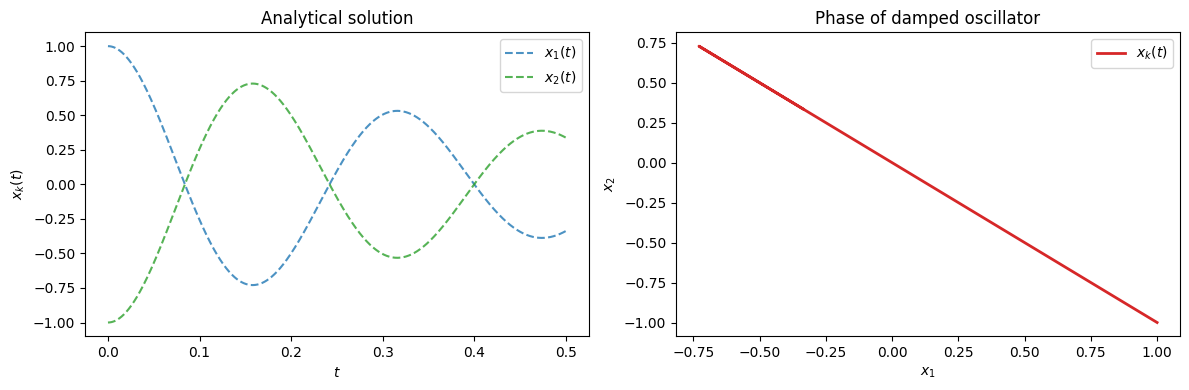

In [2]:
d, w0 = 2, 20
x1_0, v1_0 = 1, 0
x2_0, v2_0 = -1.0, 0
t = torch.linspace(0,0.5,1000)
x1, x2 = oscillator2d(d, w0, t, x1_0, v1_0, x2_0, v2_0)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(t.numpy(), x1.numpy(), label='$x_1(t)$', linestyle='--', color='tab:blue', alpha=0.8)
axes[0].plot(t.numpy(), x2.numpy(), label='$x_2(t)$', linestyle='--', color='tab:green', alpha=0.8)
axes[0].set_title('Analytical solution')
axes[0].set(xlabel='$t$', ylabel='$x_k(t)$')
axes[0].legend()

axes[1].plot(x1.numpy(), x2.numpy(), label='$x_k(t)$', linewidth=2, color='tab:red')
axes[1].set_title('Phase of damped oscillator')
axes[1].set(xlabel='$x_1$', ylabel='$x_2$')
axes[1].legend()

plt.tight_layout()
plt.show()

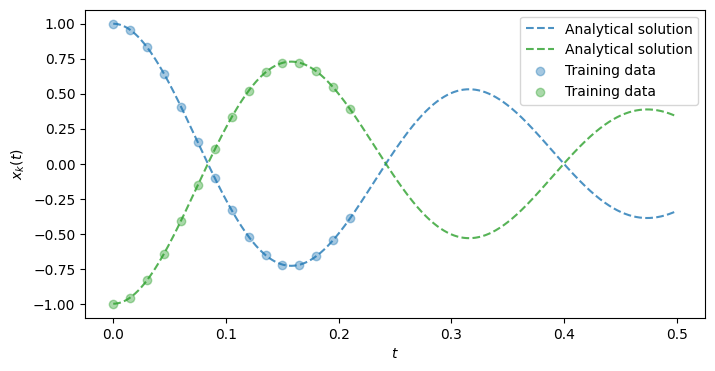

In [3]:
x1_data = x1[0:450:30]
x2_data = x2[0:450:30]
t_data = t[0:450:30]

plt.figure(figsize=(8, 4))
plt.plot(t, x1, label='Analytical solution', linestyle='--', color='tab:blue', alpha=0.8)
plt.plot(t, x2, label='Analytical solution', linestyle='--', color='tab:green', alpha=0.8)
plt.scatter(t_data, x1_data, label='Training data', color='tab:blue', alpha=0.4)
plt.scatter(t_data, x2_data, label='Training data', color='tab:green', alpha=0.4)
plt.xlabel('$t$')
plt.ylabel('$x_k(t)$')
plt.legend()
plt.show()

#### Neural Network

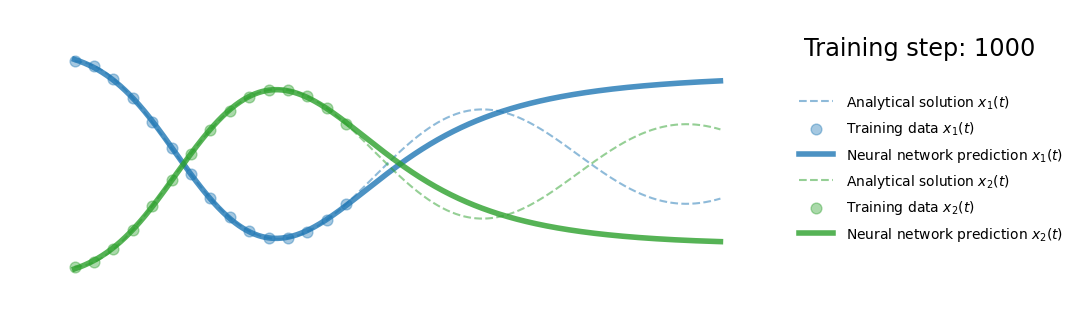

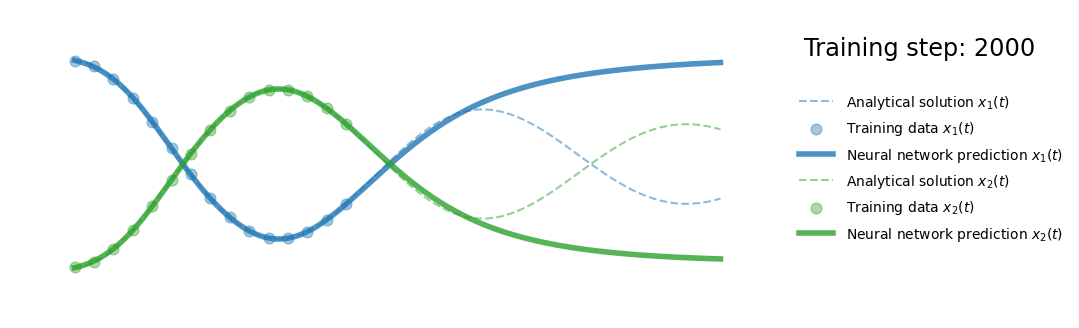

In [103]:
torch.manual_seed(59)
model = OscillatorFCN(1, 2, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

files = []
for i in range(2000):
    optimizer.zero_grad()
    yh = model(t_data.unsqueeze(1))
    loss = nn.MSELoss()(yh, torch.cat([x1_data.unsqueeze(1), x2_data.unsqueeze(1)], dim=1))

    loss.backward()
    optimizer.step()

    if (i+1) % 10 == 0:
        yh = model(t.unsqueeze(1)).detach()
        x1_pred, x2_pred = yh[:, 0], yh[:, 1]
        plot_result2d(t, x1, x2, t_data, x1_data, x2_data, x1_pred, x2_pred, step=i+1)
        file = f'plots/nn2D_{i+1:04d}.png'
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor='white')
        files.append(file)

        if (i+1) % 1000 == 0:
            plt.show()
        else:
            plt.close('all')

save_gif_PIL('figures/nn2D.gif', files, fps=20, loop=0)

#### Physics-informed Neural Network

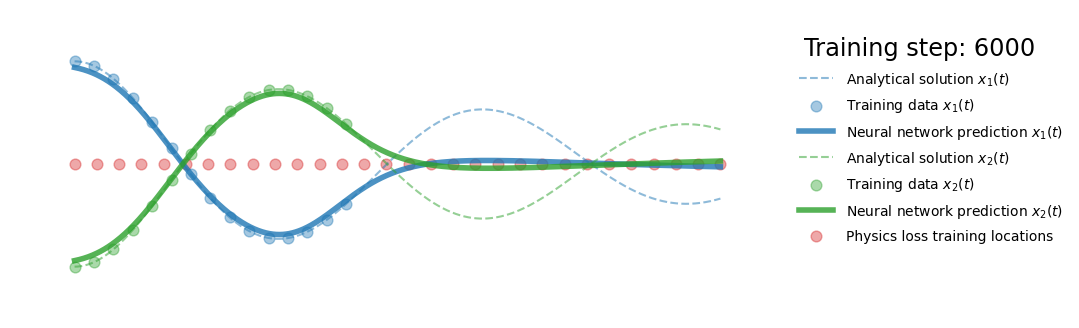

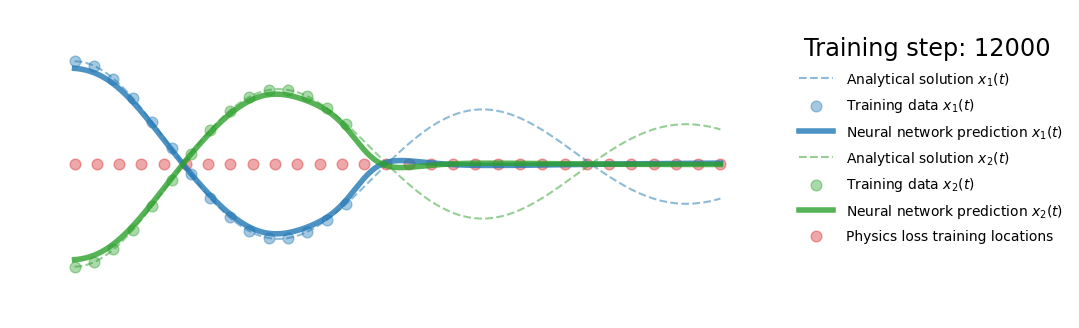

In [6]:
t_phy = torch.linspace(0,0.5,30).view(-1, 1).requires_grad_(True)

m = 1
mu, k = 2 * m * d, m * (w0**2)

torch.manual_seed(59)
model = OscillatorFCN(1, 2, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

files = []
for i in range(20000):
    optimizer.zero_grad()

    # Loss NN
    yh = model(t_data.unsqueeze(1))
    lossnn = nn.MSELoss()(yh, torch.cat([x1_data.unsqueeze(1), x2_data.unsqueeze(1)], dim=1))

    # Loss physics
    yhp = model(t_phy)
    dx = torch.autograd.grad(yhp, t_phy, torch.ones_like(yhp), create_graph=True)[0]
    d2x = torch.autograd.grad(dx, t_phy, torch.ones_like(dx), create_graph=True)[0]
    physics = d2x + mu * dx + k * yhp
    lossp = (1e-6) * torch.mean(physics**2)

    # Backpropagation
    loss = lossnn + lossp
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 150 == 0:
        yh = model(t.unsqueeze(1)).detach()
        x1p_pred, x2p_pred = yh[:, 0], yh[:, 1]
        xp = t_phy.detach()
        plot_result2d(t, x1, x2, t_data, x1_data, x2_data, x1p_pred, x2p_pred, xp=xp, step=i+1)
        file = f'plots/pinn2D_{i + 1:04d}.png'
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor='white')
        files.append(file)
  
        if (i + 1) % 6000 == 0:
            plt.show()
        else:
            plt.close('all')

save_gif_PIL('figures/pinn2D.gif', files, fps=20, loop=0)